In [21]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_data(data_folder, test_size=0.2, random_state=42):
    """
    加载 `feature_matrix.npy` 和 `labels.npy` 数据，并划分训练集和测试集。

    参数：
    - data_folder: 存放数据的文件夹路径
    - test_size: 测试集比例 (默认 20%)
    - random_state: 随机种子，保证可复现性

    返回：
    - X_train: 训练集特征，形状 (train_batches, num_windows, 15, num_channels)
    - X_test: 测试集特征，形状 (test_batches, num_windows, 15, num_channels)
    - y_train: 训练集标签，形状 (train_batches,)
    - y_test: 测试集标签，形状 (test_batches,)
    """
    # **加载数据**
    feature_path = os.path.join(data_folder, "feature_matrix.npy")
    label_path = os.path.join(data_folder, "labels.npy")

    if not os.path.exists(feature_path) or not os.path.exists(label_path):
        raise FileNotFoundError("特征文件或标签文件未找到，请检查路径！")

    X = np.load(feature_path)  # 形状 (num_batches, num_windows, 15, num_channels)
    y = np.load(label_path)  # 形状 (num_batches,)

    # **数据基本信息**
    print(f"Loaded features from {feature_path}, shape: {X.shape}")
    print(f"Loaded labels from {label_path}, shape: {y.shape}")

    # **划分训练集和测试集**
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state
        )

    # **打印数据划分信息**
    print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing set: X_test: {X_test.shape}, y_test: {y_test.shape}")

    return X_train, X_test, y_train, y_test

data_folder = r"E:\MSC\Spring\AML\GestureLink\data\FZH\processed_data"
X_train, X_test, y_train, y_test = load_data(data_folder)

# # **使用示例**
# data_folder = r"E:\MSC\Spring\AML\GestureLink\data\GZA\windowed_data"
# X_train_g, X_test_g, y_train_g, y_test_g = load_data(data_folder)

data_folder = r"E:\MSC\Spring\AML\GestureLink\data\WXR\processed_data"
X_train_W, X_test_W, y_train_W, y_test_W = load_data(data_folder)

import numpy as np

X_train = np.concatenate([X_train,X_train_W], axis=0)
X_test = np.concatenate([X_test,X_test_W], axis=0)
y_train = np.concatenate([y_train,y_train_W], axis=0)
y_test = np.concatenate([y_test,y_test_W], axis=0)

print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing set: X_test: {X_test.shape}, y_test: {y_test.shape}")


Loaded features from E:\MSC\Spring\AML\GestureLink\data\FZH\processed_data\feature_matrix.npy, shape: (390, 8, 15, 10)
Loaded labels from E:\MSC\Spring\AML\GestureLink\data\FZH\processed_data\labels.npy, shape: (390,)
Training set: X_train: (312, 8, 15, 10), y_train: (312,)
Testing set: X_test: (78, 8, 15, 10), y_test: (78,)
Loaded features from E:\MSC\Spring\AML\GestureLink\data\WXR\processed_data\feature_matrix.npy, shape: (390, 8, 15, 10)
Loaded labels from E:\MSC\Spring\AML\GestureLink\data\WXR\processed_data\labels.npy, shape: (390,)
Training set: X_train: (312, 8, 15, 10), y_train: (312,)
Testing set: X_test: (78, 8, 15, 10), y_test: (78,)
Training set: X_train: (624, 8, 15, 10), y_train: (624,)
Testing set: X_test: (156, 8, 15, 10), y_test: (156,)


In [26]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_data(data_folder, test_size=0.2, random_state=42):
    """
    加载 `feature_matrix.npy` 和 `labels.npy` 数据，并划分训练集和测试集。

    参数：
    - data_folder: 存放数据的文件夹路径
    - test_size: 测试集比例 (默认 20%)
    - random_state: 随机种子，保证可复现性

    返回：
    - X_train: 训练集特征，形状 (train_batches, num_windows, 15, num_channels)
    - X_test: 测试集特征，形状 (test_batches, num_windows, 15, num_channels)
    - y_train: 训练集标签，形状 (train_batches,)
    - y_test: 测试集标签，形状 (test_batches,)
    """
    # **加载数据**
    feature_path = os.path.join(data_folder, "feature_matrix.npy")
    label_path = os.path.join(data_folder, "labels.npy")

    if not os.path.exists(feature_path) or not os.path.exists(label_path):
        raise FileNotFoundError("特征文件或标签文件未找到，请检查路径！")

    X = np.load(feature_path)  # 形状 (num_batches, num_windows, 15, num_channels)
    y = np.load(label_path)  # 形状 (num_batches,)

    # **数据基本信息**
    print(f"Loaded features from {feature_path}, shape: {X.shape}")
    print(f"Loaded labels from {label_path}, shape: {y.shape}")

    # **划分训练集和测试集**
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state
        )

    # **打印数据划分信息**
    print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing set: X_test: {X_test.shape}, y_test: {y_test.shape}")

    return X_train, X_test, y_train, y_test

# data_folder = r"E:\MSC\Spring\AML\GestureLink\data\WXR\processed_data"
data_folder = r"E:\MSC\Spring\AML\GestureLink\windowed_data"
X_train, X_test, y_train, y_test = load_data(data_folder)



Loaded features from E:\MSC\Spring\AML\GestureLink\windowed_data\feature_matrix.npy, shape: (30, 59, 15, 7)
Loaded labels from E:\MSC\Spring\AML\GestureLink\windowed_data\labels.npy, shape: (30,)
Training set: X_train: (24, 59, 15, 7), y_train: (24,)
Testing set: X_test: (6, 59, 15, 7), y_test: (6,)


In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_and_split_data(data_folder, selected_labels=[1, 2, 3], test_size=0.2, random_state=12):
    """
    加载 `feature_matrix.npy` 和 `labels.npy` 数据，筛选标签为指定类别的数据，并划分训练集和测试集。

    参数：
    - data_folder: 存放数据的文件夹路径
    - selected_labels: 需要提取的标签列表
    - test_size: 测试集比例（默认 20%）
    - random_state: 随机种子，保证可复现

    返回：
    - X_train, X_test: 训练和测试集的特征数据
    - y_train, y_test: 训练和测试集的标签数据
    """
    # **加载数据**
    feature_path = os.path.join(data_folder, "feature_matrix.npy")
    label_path = os.path.join(data_folder, "labels.npy")

    if not os.path.exists(feature_path) or not os.path.exists(label_path):
        raise FileNotFoundError("特征文件或标签文件未找到，请检查路径！")

    X = np.load(feature_path)  # 形状 (num_batches, num_windows, 15, num_channels)
    y = np.load(label_path)  # 形状 (num_batches,)

    # **数据基本信息**
    print(f"Loaded features from {feature_path}, shape: {X.shape}")
    print(f"Loaded labels from {label_path}, shape: {y.shape}")

    # **筛选出指定标签的数据**
    mask = np.isin(y, selected_labels)  # 创建布尔掩码
    X_filtered = X[mask]  # 选取符合标签的 X
    y_filtered = y[mask]  # 选取符合标签的 y

    # **划分训练集和测试集**
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_filtered, test_size=test_size, random_state=random_state, stratify=y_filtered
    )

    # **打印划分后数据的信息**
    print(f"Train set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Test set: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    return X_train, X_test, y_train, y_test

# **使用示例**
data_folder = r"E:\MSC\Spring\AML\GestureLink\data\WXR\processed_data"
X_train_w, X_test_w, y_train_w, y_test_w = load_and_split_data(data_folder, selected_labels=label_c)
# X_train, X_test, y_train, y_test = load_and_split_data(data_folder, selected_labels=[1,2,6,8,9,11,13,16,17,18,20,26])


Loaded features from E:\MSC\Spring\AML\GestureLink\data\WXR\processed_data\feature_matrix.npy, shape: (390, 8, 200, 10)
Loaded labels from E:\MSC\Spring\AML\GestureLink\data\WXR\processed_data\labels.npy, shape: (390,)
Train set: X_train shape: (312, 8, 200, 10), y_train shape: (312,)
Test set: X_test shape: (78, 8, 200, 10), y_test shape: (78,)


In [1]:
label_c = [i for i in range(1,27)]
# label_c

In [3]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_and_split_data(data_folder, selected_labels=[1, 2, 3], test_size=0.2, random_state=12):
    """
    加载 `feature_matrix.npy` 和 `labels.npy` 数据，筛选标签为指定类别的数据，并划分训练集和测试集。

    参数：
    - data_folder: 存放数据的文件夹路径
    - selected_labels: 需要提取的标签列表
    - test_size: 测试集比例（默认 20%）
    - random_state: 随机种子，保证可复现

    返回：
    - X_train, X_test: 训练和测试集的特征数据
    - y_train, y_test: 训练和测试集的标签数据
    """
    # **加载数据**
    feature_path = os.path.join(data_folder, "feature_matrix.npy")
    label_path = os.path.join(data_folder, "labels.npy")

    if not os.path.exists(feature_path) or not os.path.exists(label_path):
        raise FileNotFoundError("特征文件或标签文件未找到，请检查路径！")

    X = np.load(feature_path)  # 形状 (num_batches, num_windows, 15, num_channels)
    y = np.load(label_path)  # 形状 (num_batches,)

    # **数据基本信息**
    print(f"Loaded features from {feature_path}, shape: {X.shape}")
    print(f"Loaded labels from {label_path}, shape: {y.shape}")

    # **筛选出指定标签的数据**
    mask = np.isin(y, selected_labels)  # 创建布尔掩码
    X_filtered = X[mask]  # 选取符合标签的 X
    y_filtered = y[mask]  # 选取符合标签的 y

    # **划分训练集和测试集**
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_filtered, test_size=test_size, random_state=random_state, stratify=y_filtered
    )

    # **打印划分后数据的信息**
    print(f"Train set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Test set: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    return X_train, X_test, y_train, y_test

# **使用示例**
data_folder = r"E:\MSC\Spring\AML\GestureLink\data\FZH\processed_data"
X_train_f, X_test_f, y_train_f, y_test_f = load_and_split_data(data_folder, selected_labels=label_c)
# X_train_f, X_test_f, y_train_f, y_test_f = load_and_split_data(data_folder, selected_labels=[1,2,6,8,9,11,13,16,17,18,20,26])


Loaded features from E:\MSC\Spring\AML\GestureLink\data\FZH\processed_data\feature_matrix.npy, shape: (390, 8, 200, 10)
Loaded labels from E:\MSC\Spring\AML\GestureLink\data\FZH\processed_data\labels.npy, shape: (390,)
Train set: X_train shape: (312, 8, 200, 10), y_train shape: (312,)
Test set: X_test shape: (78, 8, 200, 10), y_test shape: (78,)


In [4]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_and_split_data(data_folder, selected_labels=[1, 2, 3], test_size=0.2, random_state=12):
    """
    加载 `feature_matrix.npy` 和 `labels.npy` 数据，筛选标签为指定类别的数据，并划分训练集和测试集。

    参数：
    - data_folder: 存放数据的文件夹路径
    - selected_labels: 需要提取的标签列表
    - test_size: 测试集比例（默认 20%）
    - random_state: 随机种子，保证可复现

    返回：
    - X_train, X_test: 训练和测试集的特征数据
    - y_train, y_test: 训练和测试集的标签数据
    """
    # **加载数据**
    feature_path = os.path.join(data_folder, "feature_matrix.npy")
    label_path = os.path.join(data_folder, "labels.npy")

    if not os.path.exists(feature_path) or not os.path.exists(label_path):
        raise FileNotFoundError("特征文件或标签文件未找到，请检查路径！")

    X = np.load(feature_path)  # 形状 (num_batches, num_windows, 15, num_channels)
    y = np.load(label_path)  # 形状 (num_batches,)

    # **数据基本信息**
    print(f"Loaded features from {feature_path}, shape: {X.shape}")
    print(f"Loaded labels from {label_path}, shape: {y.shape}")

    # **筛选出指定标签的数据**
    mask = np.isin(y, selected_labels)  # 创建布尔掩码
    X_filtered = X[mask]  # 选取符合标签的 X
    y_filtered = y[mask]  # 选取符合标签的 y

    # **划分训练集和测试集**
    X_train, X_test, y_train, y_test = train_test_split(
        X_filtered, y_filtered, test_size=test_size, random_state=random_state, stratify=y_filtered
    )

    # **打印划分后数据的信息**
    print(f"Train set: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Test set: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    return X_train, X_test, y_train, y_test

# **使用示例**
data_folder = r"E:\MSC\Spring\AML\GestureLink\data\GZA\processed_data"
X_train_g, X_test_g, y_train_g, y_test_g = load_and_split_data(data_folder, selected_labels=label_c)
# X_train, X_test, y_train, y_test = load_and_split_data(data_folder, selected_labels=[1,2,6,8,9,11,13,16,17,18,20,26])


Loaded features from E:\MSC\Spring\AML\GestureLink\data\GZA\processed_data\feature_matrix.npy, shape: (390, 8, 200, 10)
Loaded labels from E:\MSC\Spring\AML\GestureLink\data\GZA\processed_data\labels.npy, shape: (390,)
Train set: X_train shape: (312, 8, 200, 10), y_train shape: (312,)
Test set: X_test shape: (78, 8, 200, 10), y_test shape: (78,)


In [5]:
X_train = np.concatenate([X_train_w,X_train_f,X_train_g], axis=0)
X_test = np.concatenate([X_test_w,X_test_f,X_test_g], axis=0)
y_train = np.concatenate([y_train_w,y_train_f,y_train_g], axis=0)
y_test = np.concatenate([y_test_w,y_test_f,y_test_g], axis=0)

print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing set: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training set: X_train: (936, 8, 200, 10), y_train: (936,)
Testing set: X_test: (234, 8, 200, 10), y_test: (234,)


In [80]:
X_train = np.concatenate([X_train,X_train_g], axis=0)
X_test = np.concatenate([X_test,X_test_g], axis=0)
y_train = np.concatenate([y_train,y_train_g], axis=0)
y_test = np.concatenate([y_test,y_test_g], axis=0)
print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing set: X_test: {X_test.shape}, y_test: {y_test.shape}")

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [150]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)  # 转换成 0,1,2
y_test = encoder.transform(y_test)

X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)
y_train = np.nan_to_num(y_train, nan = 0.0)
y_test = np.nan_to_num(y_test, nan = 0.0)
X_train = X_train[:,:,:,1:]
X_test = X_test[:,:,:,1:]
# **KNN 训练**
knn = KNeighborsClassifier(n_neighbors=4)  # k=5
X_train_flatten = X_train.reshape(X_train.shape[0], -1)  # (batch, 15*10)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)  # (batch, 15*10)

knn.fit(X_train_flatten, y_train)

# **KNN 预测**
y_pred = knn.predict(X_test_flatten)

# **评估**
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN 测试集准确率: {accuracy:.2f}")

# **打印分类报告**
print("分类报告:\n", classification_report(y_test, y_pred))


KNN 测试集准确率: 0.53
分类报告:
               precision    recall  f1-score   support

           0       0.45      0.56      0.50         9
           1       0.40      0.22      0.29         9
           2       0.53      1.00      0.69         9
           3       1.00      0.33      0.50         9

    accuracy                           0.53        36
   macro avg       0.60      0.53      0.49        36
weighted avg       0.60      0.53      0.49        36



In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(root_path, test_size=0.2, random_state=42):
    """
    加载预处理的手势数据，并拆分为训练集和测试集。
    
    参数：
    root_path (str): 存储 processed_gesture_data.npy 和 gesture_labels.npy 的根目录
    test_size (float): 测试集比例，默认 20%
    random_state (int): 随机种子，确保可复现性
    
    返回：
    X_train, X_test, y_train, y_test: 训练集和测试集的数据及标签
    """
    data_path = os.path.join(root_path, "processed_gesture_data.npy")
    label_path = os.path.join(root_path, "gesture_labels.npy")
    
    if not os.path.exists(data_path) or not os.path.exists(label_path):
        raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")
    
    print("Loading processed data...")
    X = np.load(data_path,allow_pickle=True)
    y = np.load(label_path,allow_pickle=True)
    
    print(f"Data shape: {X.shape}, Labels shape: {y.shape}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

data_folder = r"E:\MSC\Spring\AML\GestureLink\new_collect\fzh"  
X_train, X_test, y_train, y_test = load_data(data_folder)


Loading processed data...
Data shape: (325, 19, 100, 10), Labels shape: (325,)
Training set: (260, 19, 100, 10), Testing set: (65, 19, 100, 10)


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D


# **加载数据**
data_folder = r"E:\MSC\Spring\AML\GestureLink\data\G\windowed_data"
# X_train, X_test, y_train, y_test = load_data(data_folder)
# X_train, X_test, y_train, y_test = load_and_split_data(data_folder, selected_labels=[24, 25, 26])
X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)
y_train = np.nan_to_num(y_train, nan = 0.0)
y_test = np.nan_to_num(y_test, nan = 0.0)
# **获取数据形状**
num_batches = X_train.shape[0]  # batch 维度
num_windows = X_train.shape[1]  # 时间步（窗口数 59）
num_features = X_train.shape[2]  # 特征数（15）
num_channels = X_train.shape[3]  # 通道数（1）

# **检测类别数量**
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)  # 确保类别数正确

print(f"Corrected Classes: {num_classes}, Batches: {num_batches}, Windows: {num_windows}, Features: {num_features}, Channels: {num_channels}")

# **保持 X 形状**
X_train = X_train.reshape(num_batches, num_windows, num_features, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_windows, num_features, num_channels)
X_train = X_train[:,:,:,1:]
X_test = X_test[:,:,:,1:]

# print(X_train.shape)

num_features = X_train.shape[2] 
num_channels = X_train.shape[3]
# **标签编码**
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)  # 转换成 0,1,2
y_test = encoder.transform(y_test)

# **转换为 One-Hot**
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")  # (batch, 59, 15, 1) (batch, 3)
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")  # (batch, 59, 15, 1) (batch, 3)


# model = Sequential([
#     TimeDistributed(Flatten(), input_shape=(num_windows, 15, 10)),  # 把 (4, 10) 展平成 40
#     LSTM(64, return_sequences=True),
#     Dropout(0.3),
#     LSTM(32, return_sequences=False),
#     Dropout(0.3),
#     Dense(32, activation='relu'),
#     Dense(num_classes, activation='softmax')  # 多分类
# ])

# model = Sequential([
#     Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(num_windows, num_features * num_channels)),
#     BatchNormalization(),
#     MaxPooling1D(pool_size=2),

#     Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling1D(pool_size=2),

#     Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling1D(pool_size=2),

#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(num_classes, activation='softmax')  # 多分类输出
# ])

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)  # (batch_size, 29, 40)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)  

# # print(num_features)
# # **构建 LSTM 处理通道的模型**

model = Sequential([
    # TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu'), input_shape=(num_windows, num_features, num_channels)),  
    # TimeDistributed(GlobalAveragePooling1D()),  # 只对特征维度池化，不影响时间维度
    LSTM(64, return_sequences=True),  # 保持时间序列结构
    Dropout(0.2),
    LSTM(128, return_sequences=False),  # 输出 2D (batch, 128)
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # 最终分类
])

from tensorflow.keras.callbacks import LearningRateScheduler
def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.8  # 每 10 个 epoch，学习率减半
    return lr

# **编译模型**
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # 初始学习率
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# **使用回调函数**
lr_callback = LearningRateScheduler(lr_schedule)

# **训练时加上 callback**
history = model.fit(X_train, y_train, epochs=100, callbacks=[lr_callback], validation_data=(X_test, y_test))


# **测试模型**
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **计算准确率**
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")

# **保存模型**
# model.save("rnn_emg_model.h5")
# print("Model saved as rnn_emg_model.h5")


Corrected Classes: 26, Batches: 936, Windows: 8, Features: 200, Channels: 10
X_train shape: (936, 8, 200, 9), y_train shape: (936, 26)
X_test shape: (234, 8, 200, 9), y_test shape: (234, 26)
Epoch 1/100
30/30 [==============================] - 8s 83ms/step - loss: 3.2006 - accuracy: 0.1079 - val_loss: 3.1478 - val_accuracy: 0.1282 - lr: 1.0000e-04
Epoch 2/100
30/30 [==============================] - 1s 44ms/step - loss: 3.0917 - accuracy: 0.1346 - val_loss: 3.0538 - val_accuracy: 0.1325 - lr: 1.0000e-04
Epoch 3/100
30/30 [==============================] - 2s 52ms/step - loss: 2.9857 - accuracy: 0.1293 - val_loss: 2.9527 - val_accuracy: 0.1410 - lr: 1.0000e-04
Epoch 4/100
30/30 [==============================] - 1s 44ms/step - loss: 2.8703 - accuracy: 0.1603 - val_loss: 2.8613 - val_accuracy: 0.1538 - lr: 1.0000e-04
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 2.7710 - accuracy: 0.1720 - val_loss: 2.7863 - val_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 6/100
30

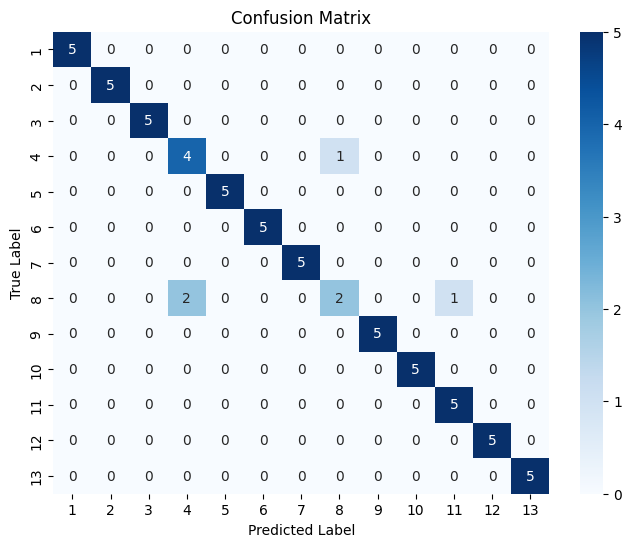

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(y_test_classes, y_pred_classes)

# 可视化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [178]:
label_C = [1,4,7,8,10,12,16,17,26]

In [145]:
label_C = [8,10,17,26]

In [5]:
from tensorflow.keras.callbacks import LearningRateScheduler
def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.8  # 每 10 个 epoch，学习率减半
    return lr

# **编译模型**
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # 初始学习率
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# **使用回调函数**
lr_callback = LearningRateScheduler(lr_schedule)

# **训练时加上 callback**
history = model.fit(X_train, y_train, epochs=100, callbacks=[lr_callback], validation_data=(X_test, y_test))
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **计算准确率**
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/100
9/9 [==============================] - 5s 137ms/step - loss: 0.2803 - accuracy: 0.9577 - val_loss: 0.3001 - val_accuracy: 0.9231 - lr: 1.0000e-04
Epoch 2/100
9/9 [==============================] - 0s 35ms/step - loss: 0.2561 - accuracy: 0.9654 - val_loss: 0.3132 - val_accuracy: 0.9385 - lr: 1.0000e-04
Epoch 3/100
9/9 [==============================] - 0s 37ms/step - loss: 0.2720 - accuracy: 0.9538 - val_loss: 0.3330 - val_accuracy: 0.8769 - lr: 1.0000e-04
Epoch 4/100
9/9 [==============================] - 0s 40ms/step - loss: 0.2532 - accuracy: 0.9423 - val_loss: 0.3174 - val_accuracy: 0.9077 - lr: 1.0000e-04
Epoch 5/100
9/9 [==============================] - 0s 41ms/step - loss: 0.2446 - accuracy: 0.9577 - val_loss: 0.3098 - val_accuracy: 0.9077 - lr: 1.0000e-04
Epoch 6/100
9/9 [==============================] - 0s 38ms/step - loss: 0.2273 - accuracy: 0.9615 - val_loss: 0.2763 - val_accuracy: 0.9077 - lr: 1.0000e-04
Epoch 7/100
9/9 [==============================] - 0s 42m

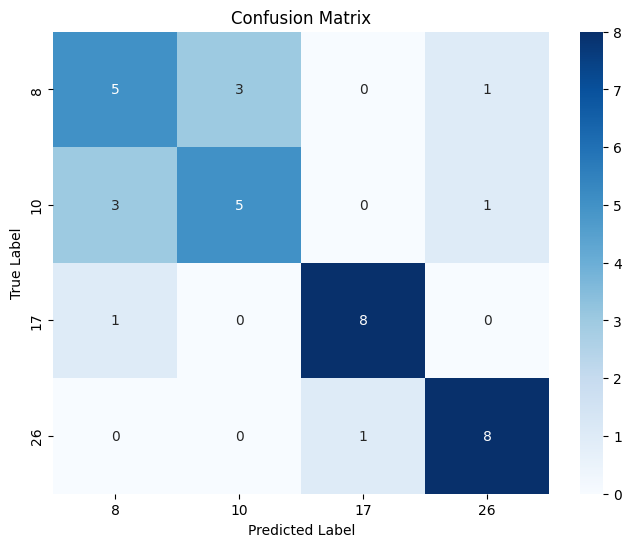

In [155]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(y_test_classes, y_pred_classes)

# 可视化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [6]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(num_windows, num_features * num_channels)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # 多分类输出
])
from tensorflow.keras.callbacks import LearningRateScheduler
def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9  # 每 10 个 epoch，学习率减半
    return lr

# **编译模型**
model.compile(
    optimizer=Adam(learning_rate=0.001),  # 初始学习率
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# **使用回调函数**
lr_callback = LearningRateScheduler(lr_schedule)

# **训练时加上 callback**
history = model.fit(X_train, y_train, epochs=100, callbacks=[lr_callback], validation_data=(X_test, y_test))
# # **编译模型**
# model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # **训练模型**
# epochs = 80

# batch_size = 8

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=epochs,
#     batch_size=batch_size,
#     verbose=1
# )

# **测试模型**
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **计算准确率**
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/100
9/9 [==============================] - 3s 50ms/step - loss: 3.3050 - accuracy: 0.0923 - val_loss: 2.5968 - val_accuracy: 0.0923 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 19ms/step - loss: 2.5707 - accuracy: 0.1692 - val_loss: 2.6192 - val_accuracy: 0.1231 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 19ms/step - loss: 2.3204 - accuracy: 0.2038 - val_loss: 2.4423 - val_accuracy: 0.1692 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 19ms/step - loss: 2.2720 - accuracy: 0.2346 - val_loss: 2.3655 - val_accuracy: 0.2154 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 18ms/step - loss: 2.1643 - accuracy: 0.2731 - val_loss: 2.2687 - val_accuracy: 0.2154 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 18ms/step - loss: 1.8546 - accuracy: 0.3731 - val_loss: 2.1507 - val_accuracy: 0.2308 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 21ms/step - loss: 1.8481 - a

In [7]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[lr_callback], validation_data=(X_test, y_test))


Epoch 1/100
9/9 [==============================] - 0s 29ms/step - loss: 0.1113 - accuracy: 0.9538 - val_loss: 0.3397 - val_accuracy: 0.9385 - lr: 3.8742e-04
Epoch 2/100
9/9 [==============================] - 0s 22ms/step - loss: 0.1444 - accuracy: 0.9423 - val_loss: 0.1460 - val_accuracy: 0.9538 - lr: 3.8742e-04
Epoch 3/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0632 - accuracy: 0.9731 - val_loss: 0.2299 - val_accuracy: 0.9385 - lr: 3.8742e-04
Epoch 4/100
9/9 [==============================] - 0s 19ms/step - loss: 0.1941 - accuracy: 0.9615 - val_loss: 0.4039 - val_accuracy: 0.8923 - lr: 3.8742e-04
Epoch 5/100
9/9 [==============================] - 0s 24ms/step - loss: 0.1740 - accuracy: 0.9577 - val_loss: 0.1129 - val_accuracy: 0.9538 - lr: 3.8742e-04
Epoch 6/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0508 - accuracy: 0.9885 - val_loss: 0.2116 - val_accuracy: 0.9385 - lr: 3.8742e-04
Epoch 7/100
9/9 [==============================] - 0s 21ms

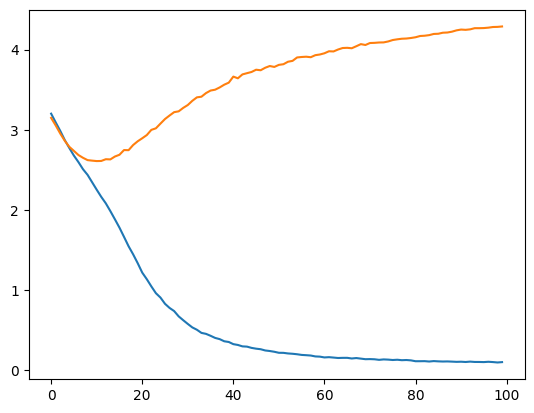

In [7]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [28]:
# X_train.shape
y_test.shape

(156, 26)

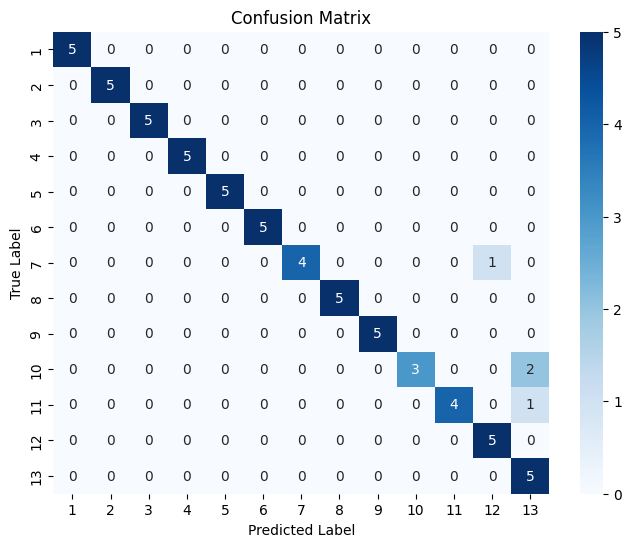

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(y_test_classes, y_pred_classes)

# 可视化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()